In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
df_train = pd.read_excel('Train.xlsx')
df_test = pd.read_excel('Test.xlsx')

df_train_X = df_train[['AT', 'V', 'AP', 'RH']]
df_train_y = df_train[['PE']]
df_test_X = df_test[['AT', 'V', 'AP', 'RH']]
df_test_y = df_test[['PE']]

df_full = pd.concat([df_train, df_test], axis=0)
df_full.reset_index(drop=True, inplace=True)
df_full

,AT,V,AP,RH,PE
0,10.54,34.03,1018.71,74.00,478.77
1,7.08,39.99,1010.55,91.44,482.83
2,14.49,41.16,1000.50,82.17,465.24
3,10.73,25.36,1009.35,100.15,469.43
4,22.88,63.91,1009.63,87.82,442.50
...,...,...,...,...,...
9563,24.99,58.79,1016.37,67.16,439.20
9564,14.22,44.99,1012.00,75.28,460.53
9565,18.76,52.90,1016.27,64.70,458.26
9566,24.82,66.54,1010.00,60.36,440.88


# Feltáró adatelemzés

## Felesleges oszlopok, sorok

Feltételezésünk szerint az oszlopok mindegyikére szükségünk van a regresszió során, így nem dobunk egy egy oszlopot sem.

A potenciálisan eldobandó sorok:
- Hiányos értékeket tartalmazó sorok
- Hibás adatokat tartalmazó sorok

In [4]:
# hiányos adatokat tartalmazó sorok száma (train)
df_full.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

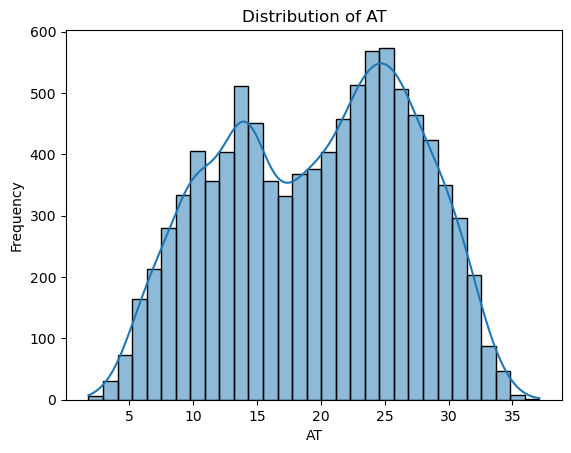

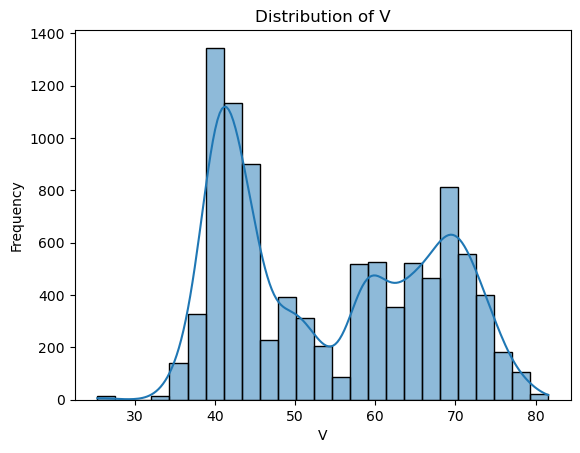

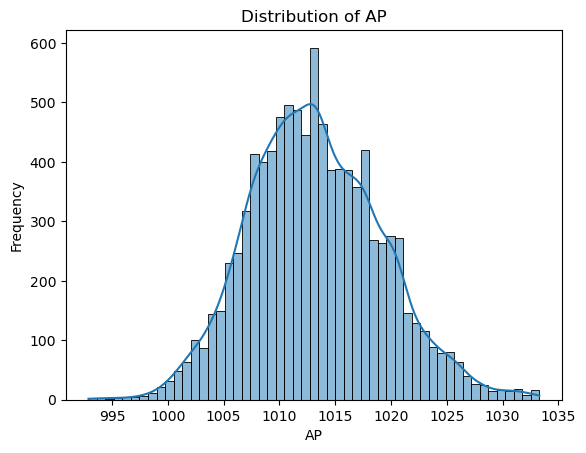

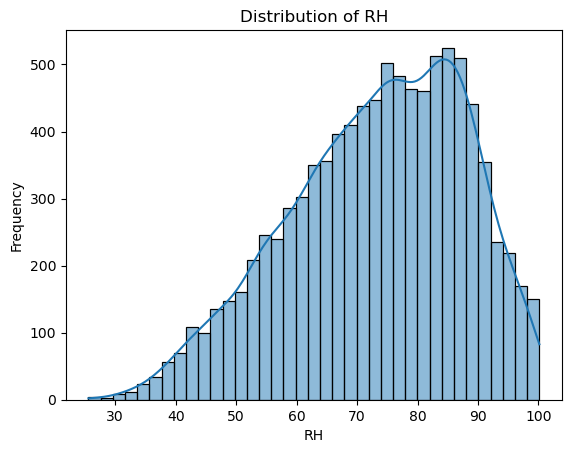

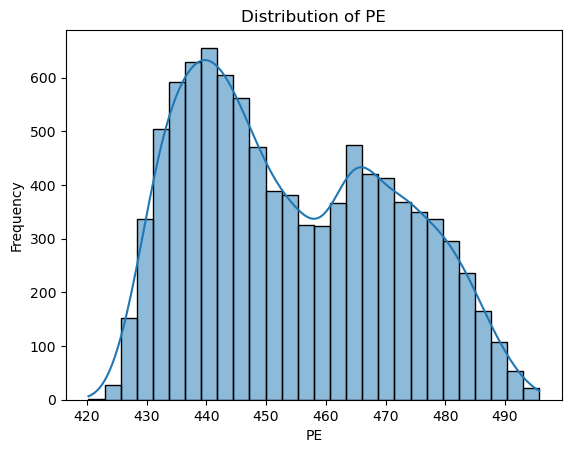

In [5]:
# Plotting the distribution of each column
for column in df_full.columns:
    sns.histplot(df_full[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

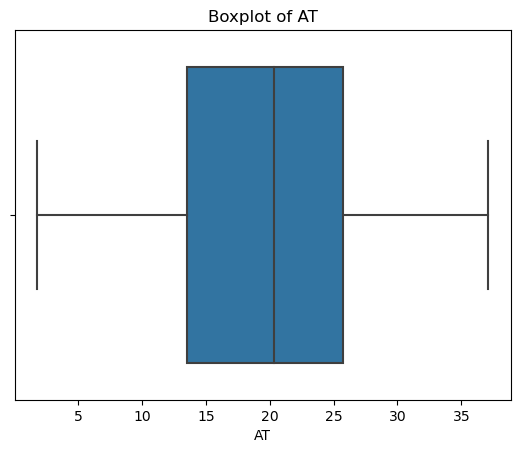

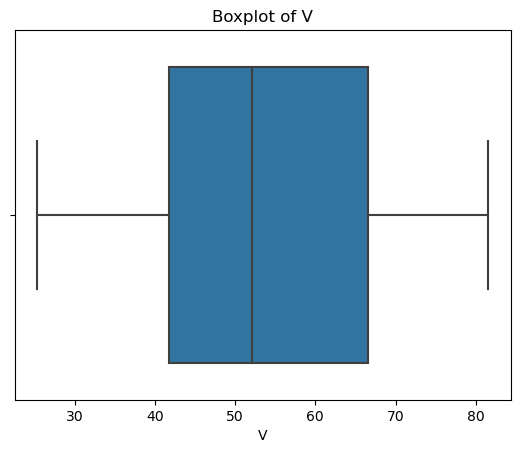

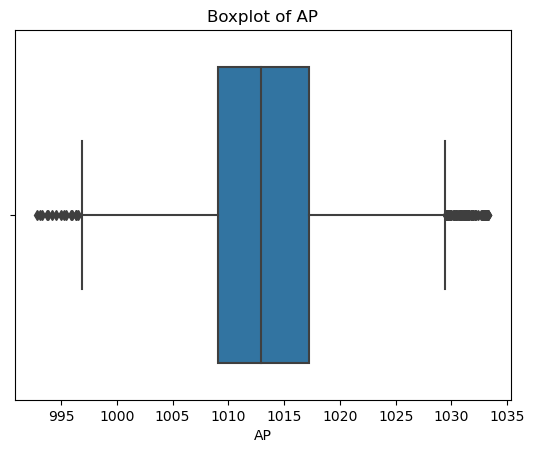

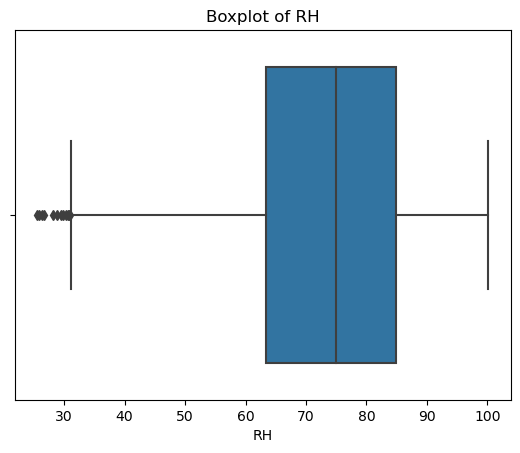

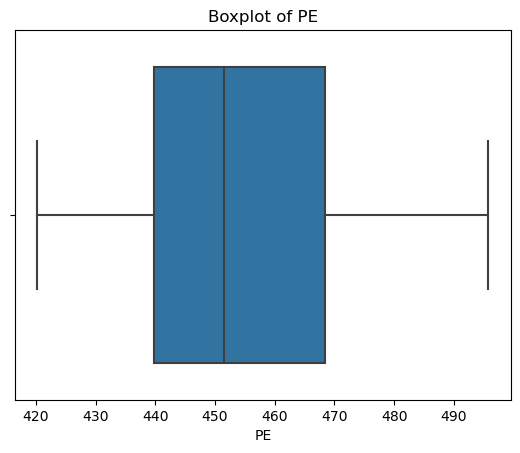

In [6]:
# Boxplots for each column
for column in df_full.columns:
    sns.boxplot(x=df_full[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

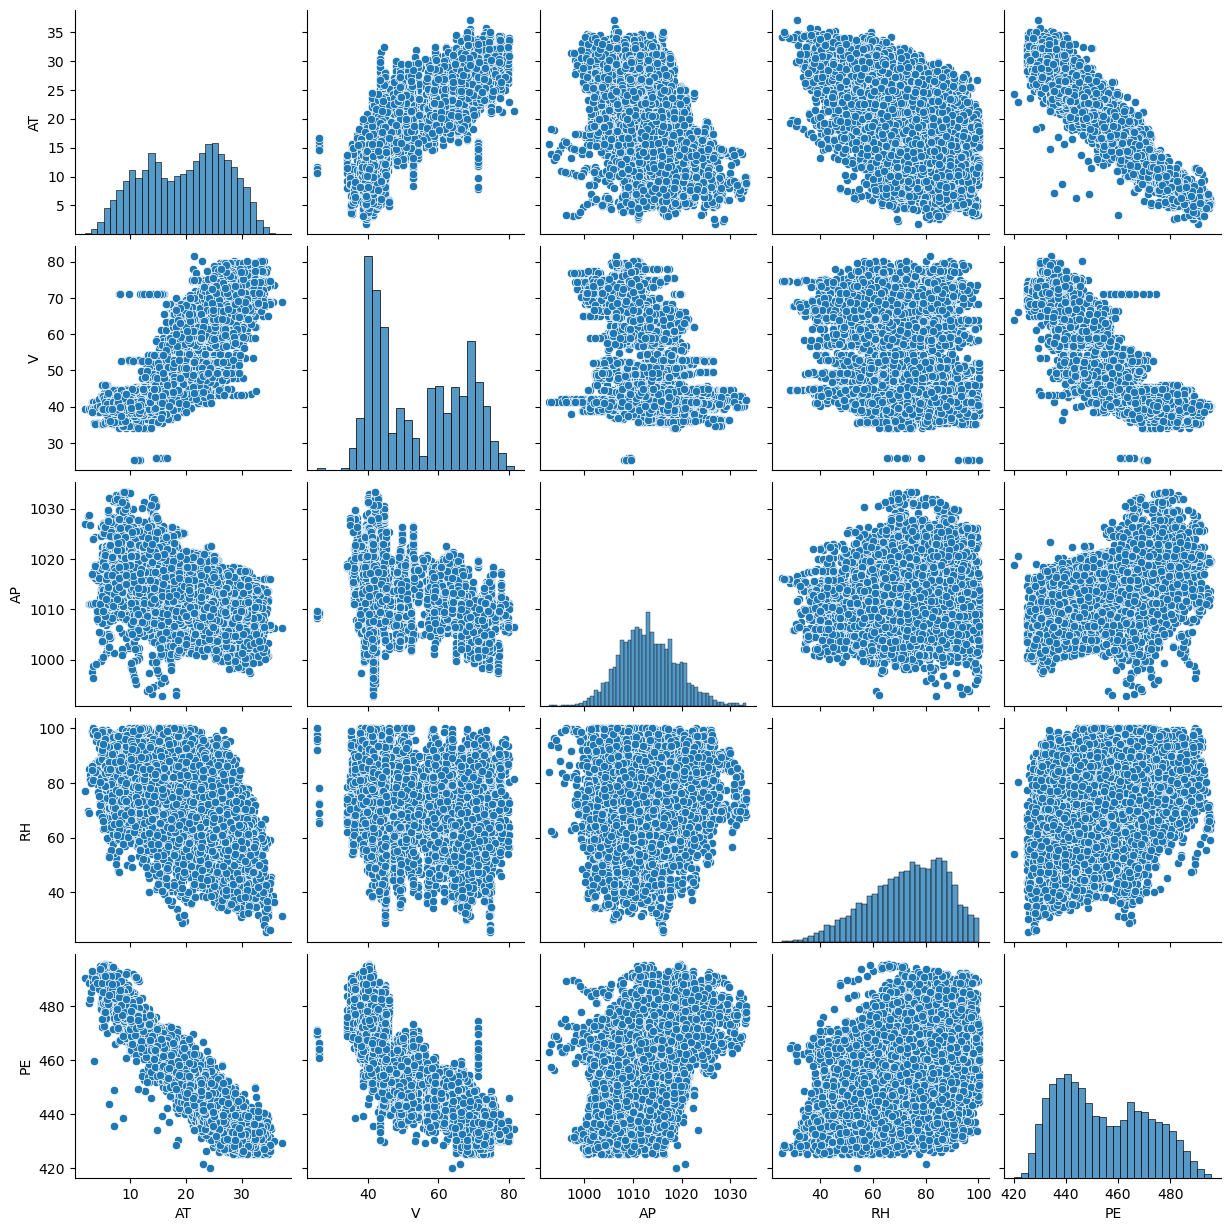

In [7]:
sns.pairplot(df_full)

In [8]:
df_full.corr().values

array([[ 1.        ,  0.84410673, -0.50754934, -0.54253465, -0.94812847],
       [ 0.84410673,  1.        , -0.41350216, -0.31218728, -0.86978031],
       [-0.50754934, -0.41350216,  1.        ,  0.09957432,  0.51842903],
       [-0.54253465, -0.31218728,  0.09957432,  1.        ,  0.3897941 ],
       [-0.94812847, -0.86978031,  0.51842903,  0.3897941 ,  1.        ]])

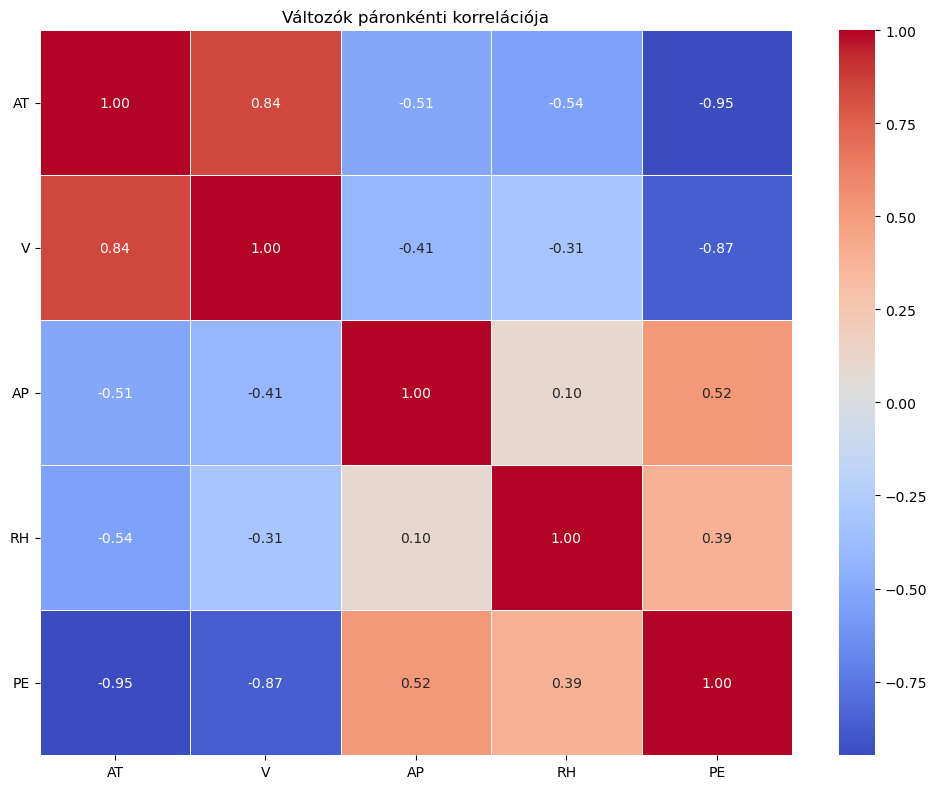

In [9]:
# Calculate correlation matrix
corr_matrix = df_full.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Változók páronkénti korrelációja')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Változó Szelekció vagy Dimenzió Redukció


A regressziós modellekhez használt bemeneti változók (input set-ek) meghatározása:
 - A 4 eredeti bemeneti változóból képzett részhalmazok.
 - PCA-val előállított input set(-ek)
 - PLS - Partial Least Squeares Regression - Mert ez eleve a független és függő változók kapcsolátának figyelembevételével végzi a változótranszformációt
 - Autoencoder-rel --> Korábbi módszerekből remélhetőleg látszik, hogy az 1, 2, és 3 változós input set-ek információtartalmai hogyan viszonyulnak egymáshoz. Az ezek közül jobban teljesítő méretű input set-ekre csinálok Autoencodert.
 
Nem használt dimenzió redukciós módszerek:
 - LDA: Ez cimkézési feladatok esetében ideális

### A 4 eredeti bemeneti változóból képzett részhalmazok

A részhalmazok a következők lesznek:

Egy elemű részhalmazok:
    Mivel a pairplot-okról és korrelációs mátrixból kiolvasható, hogy a Pe függő változót az AT határozza meg legpontosabban,
    így ezt az egy darab egy változót tartalmazó input set-et használom.
    - AT
    
Két, három és négy elemű részhalmazok:
    - Minden kombináció
    
    

In [10]:
# 1 elemű
df_train_AT = df_train[['AT', 'PE']]

# 2 elemű
df_train_AT_V = df_train[['AT', 'V', 'PE']]
df_train_AT_AP = df_train[['AT', 'AP', 'PE']]
df_train_AT_RH = df_train[['AT', 'RH', 'PE']]
df_train_V_AP = df_train[['V', 'AP', 'PE']]
df_train_V_RH = df_train[['V', 'RH', 'PE']]
df_train_AP_RH = df_train[['AP', 'RH', 'PE']]

# 3 elemű
df_train_AT_V_AP = df_train[['AT', 'V', 'AP', 'PE']]
df_train_AT_V_RH = df_train[['AT', 'V', 'RH', 'PE']]
df_train_AT_AP_RH = df_train[['AT', 'AP', 'RH', 'PE']]
df_train_V_AP_RH = df_train[['V', 'AP', 'RH', 'PE']]

### PCA

A dimenzióredukciós technikákhoz standardizálnunk kell a bemeneti változókat.

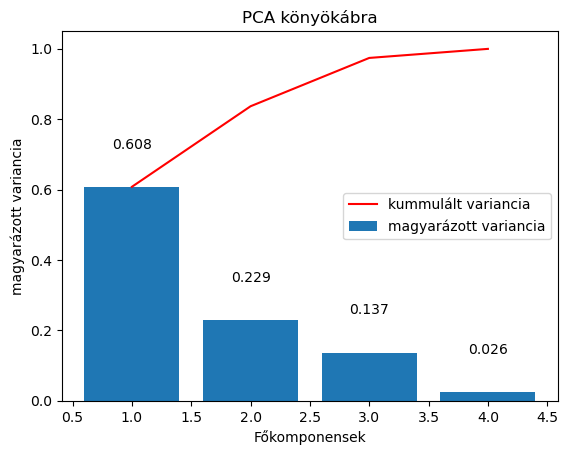

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# standard scaling of independent variables
sc = StandardScaler()
df_train_X_sc = sc.fit_transform(df_train_X)
df_test_X_sc = sc.fit_transform(df_test_X)

# PCA
pca = PCA(n_components=4)
pca.fit(df_train_X_sc)

plt.plot(range(1, df_train_X_sc.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_), label='kummulált variancia', color='red')
plt.bar(range(1, df_train_X_sc.shape[1] + 1), pca.explained_variance_ratio_, label='magyarázott variancia')
plt.title('PCA könyökábra')
plt.xlabel('Főkomponensek')
plt.ylabel('magyarázott variancia')
plt.legend(loc="right")
for bar, value in enumerate(pca.explained_variance_ratio_):
    plt.text(bar+1, value+0.1, str(round(value, 3)), ha='center', va='bottom')


Az első három főkomponens mindegyike relatív fontos, a negyedik viszont elhanyagolható, így a modellek tanításához az első három főkomponenshez tartozó értékeket használom.

In [12]:
# PCA 3 dimenzióra
pca = PCA(n_components=3)
pca.fit(df_train_X_sc)

df_train_PCA3_X = pd.DataFrame(pca.transform(df_train_X_sc), columns=['PC1', 'PC2', 'PC3'])
df_train_PCA3 = df_train_PCA3_X
df_train_PCA3['PE'] = df_train['PE']
df_train_PCA3

,PC1,PC2,PC3,PE
0,-2.021203,-0.657170,0.548860,478.77
1,-1.947415,1.206921,0.633478,482.83
2,-0.361390,1.790484,1.780146,465.24
3,-2.438007,1.655080,1.072508,469.43
4,0.567533,1.195995,-0.613887,442.50
...,...,...,...,...
8563,-0.101534,1.267244,0.806401,457.32
8564,1.307248,-1.250665,-0.176837,446.92
8565,1.979889,-0.056234,1.085194,429.34
8566,0.125109,-0.382644,-1.625591,421.57


In [13]:
pca.components_

array([[ 0.61558839,  0.56100698, -0.40229287, -0.38010859],
       [-0.04913341,  0.09534432, -0.65168514,  0.7508674 ],
       [-0.1656339 , -0.5921054 , -0.62633262, -0.47925364]])

### PLS

A PLS egy olyan dimenzió redukciós technika, amely figyelembe veszi a felaadt regressziós mivoltát és igyekszik megőrizni a független és függő változók közötti kapcsolatokat. Regressziós feladathoz ezért ezt a módszert is kipróbáltam. 

Ebben az esetben is skálázott független változókkal dolgoztam. 1-től 4 komponensig néztem meg a PLS modell teljesitményét a tanitóhalmazon. A kiértékeléshez 5-fold keresztvalidációt és R^2, MAE és RMSE pontszámot használtam.

   n_Components      RMSE       MAE        R2
0           4.0  4.586268  3.642453  0.928096
1           3.0  4.959589  3.910392  0.915930
2           2.0  5.269003  4.161157  0.905130
3           1.0  6.331970  5.048941  0.863077


Text(0.5, 1.0, 'R^2 értékek PLS komponensenként')

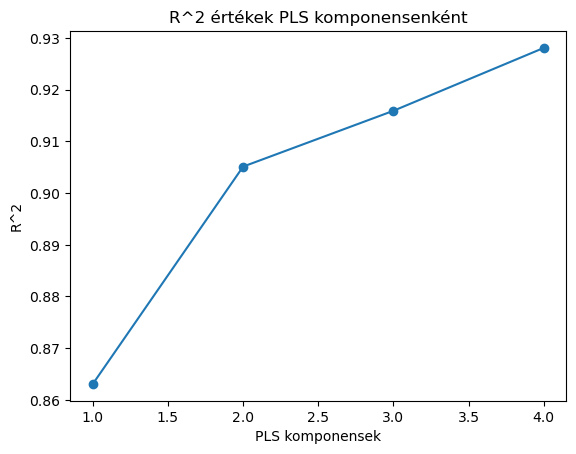

In [14]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize a list to store cross-validation scores
cv_scores = pd.DataFrame(columns=['n_Components', 'RMSE', 'MAE', 'R2'])

# Define the range of components to try
components_range = range(1, 5)  # Example range, adjust as needed

# Perform k-fold cross-validation for each number of components
for n_components in components_range:
    pls = PLSRegression(n_components=n_components)
    r2_scores = cross_val_score(pls, df_train_X_sc, df_train_y, cv=5, scoring='r2')  # Using R^2 score as the metric
    mae_scores = -cross_val_score(pls, df_train_X_sc, df_train_y, cv=5, scoring='neg_mean_absolute_error')  # Using MAE score as the metric
    rmse_scores = -cross_val_score(pls, df_train_X_sc, df_train_y, cv=5, scoring='neg_root_mean_squared_error')  # Using RMSE score as the metric
    cv_scores.loc[-1] = [n_components, rmse_scores.mean(), mae_scores.mean(), r2_scores.mean()] # adding a row
    cv_scores.index = cv_scores.index + 1  # shifting index
    cv_scores = cv_scores.sort_index()  # sorting by index

print(cv_scores)

plt.plot(cv_scores['n_Components'].to_list(), cv_scores['R2'].to_list(), marker='o')
plt.xlabel('PLS komponensek')
plt.ylabel('R^2')
plt.title('R^2 értékek PLS komponensenként')


A keresztvalidáció eredménye az, hogy a PLS modell 4 komponenssel adja a legpontosabb eredményeket r^2, MAE és RMSE esetén is. Ez azt jelenti, hogy valósznűleg nem éri meg PLS regressziót alkalmazni, de ettől függetlenül én elkésztettem a 3 és 4 komponenses PLS modelleket is.

In [15]:
# 2 komponens
pls_2comp = PLSRegression(n_components=2)
pls_2comp.fit(df_train_X_sc, df_train_y)
y_PLS2 = pls_2comp.predict(df_train_X_sc)
r2_PLS2_train = pls_2comp.score(df_train_X_sc, df_train_y)
r2_PLS2_test = pls_2comp.score(df_test_X_sc, df_test_y)

print(r2_PLS2_train, r2_PLS2_test)

# 3 komponens
pls_3comp = PLSRegression(n_components=3)
pls_3comp.fit(df_train_X_sc, df_train_y)
y_PLS3 = pls_3comp.predict(df_train_X_sc)
r2_PLS3_train = pls_3comp.score(df_train_X_sc, df_train_y)
r2_PLS3_test = pls_3comp.score(df_test_X_sc, df_test_y)

print(r2_PLS3_train, r2_PLS3_test)

# 4 komponens
pls_4comp = PLSRegression(n_components=4)
pls_4comp.fit(df_train_X_sc, df_train_y)
y_PLS4 = pls_4comp.predict(df_train_X_sc)
r2_PLS4_train = pls_4comp.score(df_train_X_sc, df_train_y)
r2_PLS4_test = pls_4comp.score(df_test_X_sc, df_test_y)

print(r2_PLS4_train, r2_PLS4_test)

df_train_PLS3_X_sc =pls_3comp.transform(df_train_X_sc)
df_train_PLS4_X_sc =pls_4comp.transform(df_train_X_sc)

0.905251472451342 0.8997612903211374
0.9160850722684725 0.9113190048943351
0.9282454838865835 0.9254444027587996


A teszt adatsoron is a 4 komponensű PLS regressziós modell adta a legjobb eredményeket.

### A következő bemeneti adatokra fogok tehát modellt illeszteni:
* 1D: AT
* 2D: minden két elemű részhalmaz az eredeti bemeneti változókból
* 3D: minden három elemű részhalmaz az eredeti bemeneti változókból, PCA, PLS3
* 4D: minden eredeti változó, PLS4

In [16]:
input_sets = [
    # 1D
    df_train_AT,
    # 2D
    df_train_AT_V,
    df_train_AT_AP,
    df_train_AT_RH,
    df_train_V_AP,
    df_train_V_RH,
    df_train_AP_RH,
    # 3D
    df_train_AT_V_AP,
    df_train_AT_V_RH,
    df_train_AT_AP_RH,
    df_train_V_AP_RH,
    df_train_PCA3_X,
    df_train_PLS3_X_sc,
    # 4D
    df_train_X,
    df_train_PLS4_X_sc
]

## Regressziós modellek

Több regressziós modell teljesítményét is meghatározom a feladat során. A különböző input set-eken tanított modell típusok:
 - Lineáris regresszió
 - Ridge regression
 - Lasso regression
 - KNN
 - decision tree
 - random forest
 - Suppert Vector regression
 - neural network

A különböző regressziós modellek teljesítményeit a különböző bemeneteken egy közös dataframe-ben tárolom el. Minden regressziós modell + bemenet kombinációhoz eltárolom az R^2, RMSE és MAE értékeket

In [23]:
df_results = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

,model,input,R2_train,R2_test,RMSE_train,RMSE_test,MAE_train,MAE_test


### Lineáris Regresszió
Mivel előre definiált a tanító és a teszt adatsor, ezért keresztvalidáció nélkül, a teljes tanító adathalmazon tanítom a modellt.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

input_set = df_train_X
lin_reg = LinearRegression()
lin_reg.fit(df_train_X, df_train_y)

df_train_y_lin_reg = lin_reg.predict(df_train_X)
df_test_y_lin_reg = lin_reg.predict(df_test_X)

print(r2_score(df_train_y, df_train_y_lin_reg), r2_score(df_test_y, df_test_y_lin_reg))
print(math.sqrt(mean_squared_error(df_train_y, df_train_y_lin_reg)), math.sqrt(mean_squared_error(df_test_y, df_test_y_lin_reg)))
print(mean_absolute_error(df_train_y, df_train_y_lin_reg), mean_absolute_error(df_test_y, df_test_y_lin_reg))
df_results.add



0.9282454838865835 0.9323745546115667
4.584934133032801 4.312333528886985
3.640278264957188 3.496981052405211
